In [1]:
import os
from os.path import dirname, abspath, join

import sys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Load local libraries
# ROOT contais the project directory 
os.chdir(dirname(os.getcwd()))
os.getcwd()

'/home/ubuntu/master_thesis'

In [3]:
# Import local libraries
from src.logger import set_logger as sl

# Load transformations
from src.transformations.CC_RRC_RVF_RHF_RA import get_transform as gt_train
from src.transformations.CC_R import get_transform as gt_valid
from src.dataset import FundusDataset
from src.RAMdatset import FundusDatasetRAM
from src.plot_images import plot_images
from src.train_validation import train_validation_phase

In [4]:
# Set-up logger
try:
    if logger is None:
        logger = sl("info")
except:
    logger = sl("info")

# Parameters

In [5]:
# Put data
epochs        = 100

lr            = 0.001

batch_size    = 256
num_workers   = os.cpu_count()
#num_workers   = 0
is_pretrained = False

im_size       = (300, 300)
is_grayscale  = False

data          = abspath('/mnt/data/ukbb_300x300_normalized/')
target_train  = abspath('./data/ukbb_metadata_qc_train.csv')
target_valid  = abspath('./data/ukbb_metadata_qc_validation.csv')

name = f"ukbb-sex-nor-{im_size[0]}x{im_size[1]}_iv3-bs{batch_size}-lr{str(lr)[2:]}"

model_pth     = abspath(f'./output/models/{name}.pth')

device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
######################################################################################
# Initial report
logger.info(f"System Python version  = {sys.version}")
logger.info(f"System Pytorch version = {torch.__version__}")
logger.info(f"System usable CPUs     = {os.cpu_count()}")

# Device setting and CUDA report 
logger.info(f"System training device = {device}")
if  torch.cuda.is_available():
    logger.info(f"System CUDA version    = {torch.version.cuda}")
    logger.info(f"System CUDA count      = {torch.cuda.device_count()}")
    logger.info(f"System CUDA name       = {torch.cuda.get_device_name()}")
    
# Load train and validation dataset
logger.info(f"Path working directory = {os.getcwd()}")
logger.info(f"Path input data        = {data}")
logger.info(f"Path to target train   = {target_train}")
logger.info(f"Path to target valid   = {target_valid}")
logger.info(f"Path model             = {model_pth}")

# Starting momentum and learning rate
logger.info(f"Model learning rate    = {lr}")
logger.info(f"Model batch_size       = {batch_size}")
logger.info(f"Model num_workers      = {num_workers}")
logger.info(f"Model pretrained       = {is_pretrained}")

2021-03-18 09:30:35,045 - INFO - System Python version  = 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
2021-03-18 09:30:35,047 - INFO - System Pytorch version = 1.6.0
2021-03-18 09:30:35,048 - INFO - System usable CPUs     = 64
2021-03-18 09:30:35,048 - INFO - System training device = cuda:0
2021-03-18 09:30:35,049 - INFO - System CUDA version    = 10.2
2021-03-18 09:30:35,050 - INFO - System CUDA count      = 8
2021-03-18 09:30:35,070 - INFO - System CUDA name       = Tesla V100-SXM2-16GB
2021-03-18 09:30:35,071 - INFO - Path working directory = /home/ubuntu/master_thesis
2021-03-18 09:30:35,072 - INFO - Path input data        = /mnt/data/ukbb_300x300_normalized
2021-03-18 09:30:35,073 - INFO - Path to target train   = /home/ubuntu/master_thesis/data/ukbb_metadata_qc_train.csv
2021-03-18 09:30:35,073 - INFO - Path to target valid   = /home/ubuntu/master_thesis/data/ukbb_metadata_qc_validation.csv
2021-03-18 09:30:35,074 - INFO - Path model             = /home/ubuntu/master_thes

# Dataset

In [7]:
#imgs_dir=None, target_file=None, scale=1, target_size=512, augment=True
logger.info(f"Loading datasets")
dataset = dict()
dataset["train"] = FundusDatasetRAM(imgs_dir=data, target_file=target_train, target="sex", augment=True)
dataset["valid"] = FundusDatasetRAM(imgs_dir=data, target_file=target_valid, target="sex", augment=False)

# Get the size of the datsets train and valid(ation)
size = dict()
size["train"] = len(dataset["train"])
size["valid"] = len(dataset["valid"])
logger.info(f"Dataset size training   = {size['train']}")
logger.info(f"Dataset size validation = {size['valid']}")
logger.info(f"Dataset labels/classes  = {dataset['train'].classes}")

2021-03-18 09:30:40,741 - INFO - Loading datasets
2021-03-18 09:39:22,762 - INFO - Dataset size training   = 120000
2021-03-18 09:39:22,764 - INFO - Dataset size validation = 10910
2021-03-18 09:39:22,764 - INFO - Dataset labels/classes  = ['female', 'male']


2021-03-18 09:39:47,680 - INFO - Loading dataloaders
2021-03-18 09:39:47,681 - INFO - Plot sample images
 male female female  male  male female  male  male


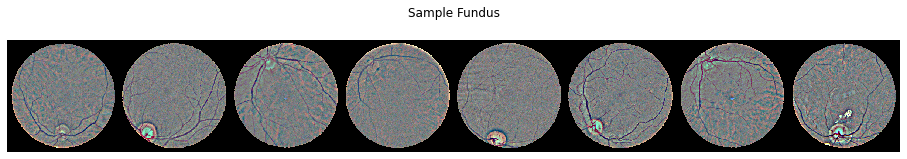

In [8]:
# Dataloader for train and valid(ation)
logger.info(f"Loading dataloaders")
dataloader = dict()
dataloader["train"] = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
dataloader["valid"] = DataLoader(dataset["valid"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

######################################################################################
# Get sample images
logger.info(f"Plot sample images")
plot_images(dataloader["train"], dataset["train"].classes, title="Sample Fundus", save=name)

In [9]:
# Load model
model = models.inception_v3(pretrained=is_pretrained,
                            aux_logits=False)

logger.info(f"Model loading            = {model.__class__.__name__}")

# Get number of features in the model
n_ftrs = model.fc.in_features
logger.info(f"Model number of features = {n_ftrs}")

# Add linear layer to the data
model.fc = nn.Linear(n_ftrs, len(dataset["train"].classes))

######################################################################################
# Send model to device, 
# if CUDA count is greater than 1 use multiple GPUs
model = model.to(device)
usable_devices =list(range(torch.cuda.device_count()))
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=usable_devices, output_device=device)
    logger.info(f"Let's use {torch.cuda.device_count()} GPUs!")

######################################################################################
# Get Optimization and crossentropy
criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

######################################################################################
results = train_validation_phase(model=model,
                               dataset=dataset,
                               dataloader = dataloader,
                               device=device,
                               epochs=epochs,
                               criterion=criterion,
                               optimizer=optimizer,
                               save = model_pth,
                               logger=logger)

/home/ubuntu/.miniconda3/envs/mt/lib/python3.7/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


2021-03-18 09:41:01,771 - INFO - Model loading            = Inception3
2021-03-18 09:41:01,772 - INFO - Model number of features = 2048
2021-03-18 09:41:01,830 - INFO - Let's use 8 GPUs!
2021-03-18 09:42:05,499 - INFO - Epoch [  1/100] - Batch [     0/120000] ( 0%) - Loss 0.7084
2021-03-18 09:43:05,214 - INFO - Epoch [  1/100] - Batch [ 25600/120000] (21%) - Loss 0.6840
2021-03-18 09:44:04,593 - INFO - Epoch [  1/100] - Batch [ 51200/120000] (43%) - Loss 0.6858
2021-03-18 09:45:03,255 - INFO - Epoch [  1/100] - Batch [ 76800/120000] (64%) - Loss 0.6506
2021-03-18 09:45:58,406 - INFO - Epoch [  1/100] - Batch [102400/120000] (85%) - Loss 0.6477
2021-03-18 09:46:37,149 - INFO - Current lr: 0.001
2021-03-18 09:46:37,150 - INFO - train, Loss: 0.6748 Acc: 0.5821
2021-03-18 09:47:02,419 - INFO - Epoch [  1/100] - Batch [     0/ 10910] ( 0%) - Loss 1.0152
2021-03-18 09:47:20,464 - INFO - Current lr: 0.001
2021-03-18 09:47:20,465 - INFO - valid, Loss: 0.9885 Acc: 0.5275
2021-03-18 09:47:20,466

KeyboardInterrupt: 